In [1]:
import pandas

pandas.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
agency_spending_data = pandas.read_csv('../data/csv/Aggregate_federal_spending_country_month_agency.csv')

### First, we will look for the unique departments and positions within the spending dataset

In [17]:
agencies = pandas.unique(agency_spending_data['agency'])
pandas.DataFrame({'Agencies': agencies})

,Agencies
0,ADMINISTRATIVE CONFERENCE OF THE U.S. (ACUS)
1,AFRICAN DEVELOPMENT FOUNDATION (EOP)
2,AGENCY FOR INTERNATIONAL DEVELOPMENT (USAID)
3,AMERICAN BATTLE MONUMENTS COMMISSION (ABMC)
4,ARMED FORCES RETIREMENT HOME (AFRH)
5,BROADCASTING BOARD OF GOVERNORS (BBG)
6,COMMISSION ON CIVIL RIGHTS (USCCR)
7,COMMITTEE FOR PURCHASE FROM PEOPLE WHO ARE BLI...
8,COMMODITY FUTURES TRADING COMMISSION (CFTC)
9,CONSUMER FINANCIAL PROTECTION BUREAU (CFPB)


## Next, we will import the data for senators


In [60]:
import json
import datetime

TYPE_SENATOR = 'sen'
VALID_PARTIES = ['Republican', 'Democrat']

with open('../data/json/legislators-current.json') as f:
    current_legislators = json.load(f)

with open('../data/json/legislators-historical.json') as f:
    historical_legislators = json.load(f)

senators = pandas.DataFrame()

for dataset in [historical_legislators, current_legislators]:
    for legislator in dataset:
        parse_date = lambda date: datetime.datetime.strptime(date, '%Y-%m-%d')
        terms = [
            {
                'termStart': parse_date(term['start']),
                'termEnd': parse_date(term['end']),
                'party': term['party']
            }
            for term in legislator['terms']
            if (term['type'] == TYPE_SENATOR
                and term.get('party') in VALID_PARTIES
                and parse_date(term['start']) > datetime.datetime(1990, 1, 1)
            )
        ]

        senators = senators.append(terms)

senators = senators.reset_index();

## Next, we will calculate every time the senate majority changed within our data 

In [75]:
majorities = pandas.DataFrame()

#print(senators[
#        (senators['termStart'] <= datetime.datetime(2005, 1, 1))
#        & (senators['termEnd'] >= datetime.datetime(2005, 1, 1))
#    ])
for year in range(2000, 2021):
    for month in range(1, 13):
        date_to_check = datetime.datetime(year, month, 1)
        senators_at_time = senators[
            (senators['termStart'] <= date_to_check)
            & (senators['termEnd'] >= date_to_check)
        ]
        
        
        majority_party = senators_at_time['party'].mode()[0]
        
        if len(majorities) == 0 or majorities.iloc[-1]['party'] != majority_party:
            majorities = majorities.append([{'date': date_to_check, 'party': majority_party}])

majorities

,date,party
0,2000-01-01,Republican
0,2001-02-01,Democrat
0,2002-12-01,Republican
0,2003-01-01,Democrat
0,2003-02-01,Republican
0,2007-02-01,Democrat
0,2015-02-01,Republican


### Given this, and other information, we will attempt to map the departments themselves

In [70]:
position_agency_mappings = {
    'Secretary of State': 'DEPARTMENT OF STATE (DOS)',
    'Secretary of Agriculture': 'DEPARTMENT OF AGRICULTURE (USDA)',
    'Secretary of Commerce': 'DEPARTMENT OF COMMERCE (DOC)',
    'Secretary of Housing and Urban Development': 'DEPARTMENT OF HOUSING AND URBAN DEVELOPMENT (HUD)',
    'Secretary of the Treasury': 'DEPARTMENT OF THE TREASURY (TREAS)',
    'Attorney General': 'DEPARTMENT OF JUSTICE (DOJ)',
    'Secretary of Defense': 'DEPARTMENT OF DEFENSE (DOD)',
    'Secretary of Education': 'DEPARTMENT OF EDUCATION (ED)',
    'Secretary of Health and Human Services': 'DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS)',
    'Secretary of the Interior': 'DEPARTMENT OF THE INTERIOR (DOI)',
    'Secretary of Veterans Affairs': 'DEPARTMENT OF VETERANS AFFAIRS (VA)',
    'Secretary of Energy': 'DEPARTMENT OF ENERGY (DOE)',
    'Secretary of Transportation': 'DEPARTMENT OF TRANSPORTATION (DOT)',
    'Secretary of Labor': 'DEPARTMENT OF LABOR (DOL)',
    'Secretary of Homeland Security': 'DEPARTMENT OF HOMELAND SECURITY (DHS)',
}

In [94]:
import datetime
from typing import Union

def convert_date_to_be_relative_year(raw_date: Union[str, datetime.datetime]) -> float:
    if isinstance(raw_date, str):
        date = datetime.datetime.strptime(raw_date, '%Y-%m-%d')
        days_of_year = int(date.strftime('%j'))
        year = int(date.strftime('%Y'))
    else:
        days_of_year = raw_date.timetuple().tm_yday
        year = raw_date.year

    return year + days_of_year / 366

def convert_month_to_be_relative_year(month: int, year: int) -> float:
    return year + month / 12

In [66]:
from typing import TypeVar, Union
import math
import numpy

# Given a dataframe that contains year and month, add a new column called "relative_date" that
# represents the month/year combo as a decimal relative to the current year.
def add_relative_date_to_df(dataframe: pandas.DataFrame) -> None:
    T = TypeVar('T')
    def convert_to_int_if_possible(value: T) -> Union[int, T]:
        try:
            return int(value)
        except ValueError:
            return value

    dataframe['relative_date'] = convert_month_to_be_relative_year(
        dataframe['month'].apply(convert_to_int_if_possible),
        dataframe['year'].apply(convert_to_int_if_possible)
    )

# Fill in any missing entries from min_date to max_date within the dataframe.
# Both min_date and max_date must be relative dates (as in decimals relative to a year). If None, the start/end of the dataframe are used.
def add_missing_entries_for_agency(dataframe: pandas.DataFrame, min_date: float = None, max_date: float = None) -> pandas.DataFrame:
    min_date = min_date if min_date is not None else dataframe['relative_date'].min()
    max_date = max_date if max_date is not None else dataframe['relative_date'].max()
    missing_items = pandas.DataFrame(columns=['sum', 'relative_date'])
    for relative_date in numpy.arange(min_date, max_date + 1/12, 1/12):
        date_spending = dataframe[numpy.isclose(dataframe['relative_date'], relative_date)]
        if len(date_spending) == 0:
            missing_items = missing_items.append(
                pandas.DataFrame({
                    'sum': [0],
                    'relative_date': [relative_date],
                }),
            )

    return pandas.concat([dataframe, missing_items]).sort_values('relative_date')

# Run any data processing needed for a given dataframe with spending info.
def process_spending_frame(spending_frame: pandas.DataFrame) -> pandas.DataFrame:
    # Add missing dates before performing normalization - doing makes a moving average more accurate
    res = add_missing_entries_for_agency(spending_frame)
    res['sum'] = res['sum'].rolling(12).mean()
    res.reset_index()

    return res

In [96]:
from dataclasses import dataclass

@dataclass
class SpendingSet:
    domestic_spending: pandas.DataFrame
    foreign_spending: pandas.DataFrame

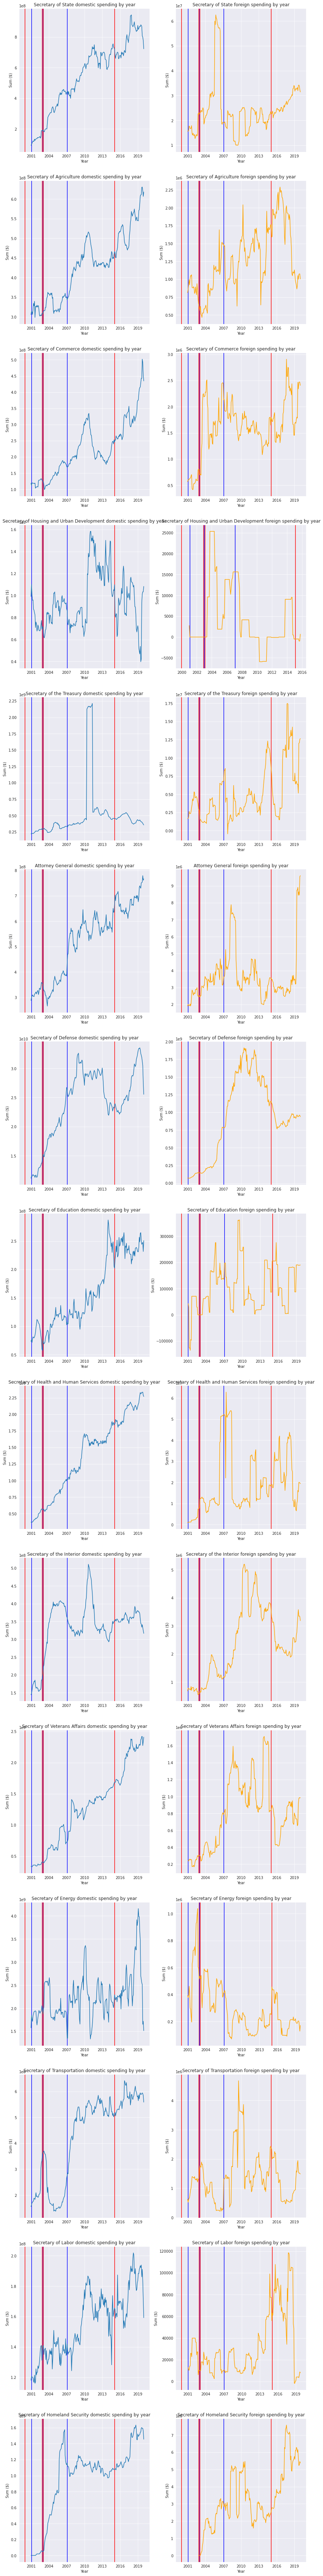

In [98]:
import matplotlib.ticker
from matplotlib import pyplot as plt
import seaborn as sns
import math

sns.set_style("darkgrid")
spending_by_cabinet_figure = plt.figure(figsize=(14, 128))
add_relative_date_to_df(agency_spending_data)

# Will later be used for converting the data to a format D3 can read
spending_sets = {}

for i, position in enumerate(position_agency_mappings.keys()):
    domestic_plot = spending_by_cabinet_figure.add_subplot(len(position_agency_mappings), 2, i * 2 + 1)
    foreign_plot = spending_by_cabinet_figure.add_subplot(len(position_agency_mappings), 2, i * 2 + 2)

    for majority in majorities.itertuples():
        relative_year = convert_date_to_be_relative_year(majority.date.to_pydatetime())
        for plot in [domestic_plot, foreign_plot]:
            plot.axvline(relative_year, color='red' if majority.party == 'Republican' else 'blue')

    agency_spending = agency_spending_data[
        (agency_spending_data['agency'] == position_agency_mappings[position])
        # Filter out valid years
        & (agency_spending_data['year'] < 2020)
        & (agency_spending_data['year'] >= 2000)
    ]

    domestic_spending = process_spending_frame(
        agency_spending[agency_spending['country'] == 'USA']
    )

    foreign_spending = process_spending_frame(
        agency_spending[agency_spending['country'] != 'USA'].groupby(['relative_date'], as_index=False)['sum'].sum()
    )

    # Save these dataframes for later, so we can process them when exporting graphs for D3
    spending_sets[position] = SpendingSet(domestic_spending, foreign_spending)

    chart = sns.lineplot(
        x=domestic_spending["relative_date"],
        y=domestic_spending["sum"],
        ax=domestic_plot
    )
    chart.set_title(position + ' domestic spending by year')
    chart.set(xlabel="Year", ylabel="Sum ($)")
    chart.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

    chart = sns.lineplot(
        x=foreign_spending['relative_date'],
        y=foreign_spending['sum'],
        color='orange',
        ax=foreign_plot
    )
    chart.set_title(position + ' foreign spending by year')
    chart.set(xlabel="Year", ylabel="Sum ($)")
    chart.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
plt.show()

## Convert the data into a format readable by D3 for putting online

In [24]:
import json
from typing import List, TypeVar

T = TypeVar('T')

def make_normalized_list(l: List[T]) -> List[T]:
    return [
                'NaN' if isinstance(item, float) and math.isnan(item) else item
                for item in l
            ]

d3_objects = []
for position, spending_set in spending_sets.items():
    domestic_spending = add_missing_entries_for_agency(spending_set.domestic_spending, max_date=2020)
    foreign_spending = add_missing_entries_for_agency(spending_set.foreign_spending, max_date=2020)
    # Set up the structure of the json, and get every field into a json-able format
    res = {
            'position': position,
            'domestic_dates': make_normalized_list(domestic_spending['relative_date'].tolist()),
            'domestic_spending': make_normalized_list(domestic_spending['sum'].tolist()),
            'foreign_dates': make_normalized_list(foreign_spending['relative_date'].tolist()),
            'foreign_spending': make_normalized_list(foreign_spending['sum'].tolist()),
            'position_dates': make_normalized_list(cabinet_data[cabinet_data['Position'] == position].sort_values('Confirmed')['Confirmed'].tolist())
        }

    d3_objects.append(res)

print(d3_objects)
with open('../data/json/cabinet-data-changes.json', 'w') as f:
    json.dump(d3_objects, f)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[{'position': 'Secretary of State', 'domestic_dates': [2000.0833333333333, 2000.1666666666667, 2000.25, 2000.3333333333333, 2000.4166666666667, 2000.5, 2000.5833333333333, 2000.6666666666667, 2000.75, 2000.8333333333333, 2000.9166666666667, 2001.0, 2001.0833333333333, 2001.1666666666667, 2001.25, 2001.3333333333333, 2001.4166666666667, 2001.5, 2001.5833333333333, 2001.6666666666667, 2001.75, 2001.8333333333333, 2001.9166666666667, 2002.0, 2002.0833333333333, 2002.1666666666667, 2002.25, 2002.3333333333333, 2002.4166666666667, 2002.5, 2002.5833333333333, 2002.6666666666667, 2002.75, 2002.8333333333333, 2002.9166666666667, 2003.0, 2003.0833333333333, 2003.1666666666667, 2003.25, 2003.3333333333333, 2003.4166666666667, 2003.5, 2003.5833333333333, 2003.6666666666667, 2003.75, 2003.8333333333333, 2003.9166666666667, 2004.0, 2004.0833333333333, 2004.1666666666667, 2004.25, 2004.3333333333333, 2004.4166666666667, 2004.5, 2004.5833333333333, 2004.6666666666667, 2004.75, 2004.8333333333333, 200